# Asignación 2 Punto 1: Solución numérica de una heteroestructura, Mecánica Cuántica Avanzada

## Contenido
1. [Planteamiento del problema](#probstate)
2. [Implementación](#imp)
3. [Resultados y análisis](#results)
4. [Fuentes](#bib)

## Planteamiento del problema <a name="probstate"></a>

Una heteroestructura es la unión de múltiples materiales semiconductores. Estos materiales tienen distintas brechas entre sus bandas de conducción y de valencia, y pueden crear por lo tanto diversos tipos de pozos cuánticos. En esta asignación se usará una capa de GaAs rodeada por dos capas gruesas de Ga$_{1-x}$Al$_{x}$, que bajo la aproximación de masa efectiva tiene la apariencia de un pozo cuántico finito:

$$ V(x)=\left\{\begin{array}{ll}
0 & |x| \leq a / 2 \\
V_{0} & |x|>a / 2
\end{array}\right. $$

La ecuación de Schrödinger independiente del tiempo es

$$ \frac{d^{2} \Psi}{d x^{2}}=-\frac{2 m}{\hbar^{2}}(E-V(x)) \Psi(x) .$$

Para evitar lidiar con números muy grandes o muy pequeños, es útil re escribir la ecuación diferencial en unidades que sean naturales al sistema físico en cuestión. Como $a$ es la cantidad representativa de distancia, para medir las distancias en unidades de $a$ se define $\bar{x} = \frac{x}{a}$. De manera similar, se puede tomar $\hbar^{2} / m a^{2}$ como la unidad de medida de la energía definiendo $\bar{E}=\frac{E}{\frac{\hbar^2}{m a^2}}$ y $\bar{V}(\bar{x})=\frac{V(\bar{x})}{\frac{\hbar^2}{m a^2}}$.
Con estas variables la ecuación de Schrödinger queda

$$ \frac{d^{2} \Psi}{d \bar{x}^{2}}=-2(\bar{E}-\bar{V}(\bar{x})) \Psi .$$

Como esta es una ecuación diferencial ordinaria de segundo orden, para usar los métodos numéricos de solución de ecuaciones diferenciales ordinarias es necesario transformarlo en un sistema de dos ecuaciones diferenciales ordinarias de primer orden. Definiendo el vector $\mathbf{y}$ como $\mathbf{y}=(y_1 =\Psi,y_2 = \Psi^{\prime})$, la ecuación de Schrödinger se puede escribir como

$$\begin{array}{l}
y_{1}^{\prime}(\bar{x})=y_{2}(\bar{x}) \\
y_{2}^{\prime}(\bar{x})=-2(\bar{E}-\bar{V}(\bar{x})) y_{1}(\bar{x}).
\end{array}$$

Para estimar un valor apropiado de $V_0$ en las unidades escogidas se pueden usar los autovalores de energía del pozo cuántico infinito: $(\pi^2 \hbar^{2} n^{2} / 2 m a^{2})/\frac{\hbar^2}{m a^2}\approx 5 n^2$. Las energías más bajas son entonces 5, 20, 45, 80, etc. En este orden debe estar el valor $V_0$, pues un valor mucho menor haría que el electrón tuviera muy pocos estados ligados y un valor mucho mayor hará que el pozo parezca infinito. De aquí en adelante se usará $V_0=50$, en la práctica este valor dependerá de la discontinuidad en la unión de las bandas de conducción de el GaAs y el material específico que se escoja para rodearlo Ga$_{1-x}$Al$_{x}$.

## Implementación <a name="imp"></a>

Se cargan primero las librerías, funciones y ajustes que se van a usar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
from scipy.integrate import solve_bvp
from scipy.optimize import root_scalar
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Mientras existen muchos métodos para solucionar sistemas de ecuaciones diferenciales ordinarias sujetos a dos condiciones de frontera, la librería SciPy de Python cuenta con la función [*solve_bvp*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#r25f8479e577a-1) para resolver este tipo sistemas y será usada por su conveniencia. La definición de las funciones será realizada de acuerdo a lo requerido por la documentación de *solv_bvp*.

La función *solve_bvp* tiene, por defecto, un tolerancia de 0.001.

Se define la función *schro_eq* como el lado derecho del sistema de ecuaciones especificado anteriormente. Los argumentos que entran en esta función son arreglos n-dimensionales: x, representando el eje x, de dimensión (m,); y, de dimensiones (n,m); también se incluye un parámetro p de dimensión (k,). La función devuelve un arreglo de dimensiones (n,m). 

En nuestro caso, el sistema consta de dos ecuaciones, por lo que n=2, y nuestro parámetro, aún desconocido, es la energía E, con lo que k=1.

In [2]:
def schro_eq(x, y, p):
    E=p[0]
    return np.vstack((y[1], -2*(E - V(x))*y[0]))

donde el potencial $V(x)$ es 

In [3]:
def V(x, V0=50, a=1):
    if np.iterable(x):
        return np.array([V(xi, V0, a) for xi in x])
    elif np.abs(x) < a/2:
        return 0
    else:
        return V0

la definición del potencial se hace de esta manera para que $x$ pueda entrar como un arreglo.

Ahora se consideran las condiciones de frontera, asumiendo que en estas la función de onda ha decaído hasta prácticamente cero, sin embargo, como se está considerando un pozo cuántico finito, para obtener una soución no trivial, se asigna a $\Psi ' (x)$ un pequeño valor, indicando que la pendiente allí no es cero.

En los métodos que aproximan la solución de un problema de valores de frontera, una medida del error es el residuo entre los valores encontrados mediante el método en estos puntos, y los definidos previamente. Para obtener este residuo se define una función *boundary*, cuyos argumentos son el parámetro p y los valores de frontera para para $y_1$ y $y_2$:

$$\textbf{y}(x_a) = (y_1(x_a), y_2(x_a)),$$

$$\textbf{y}(x_b) = (y_1(x_b), y_2(x_b)),$$

y devuelve los residuos de estos respecto a los valores de frontera definidos, en nuestro caso, $y_1(x_a) = y_1(x_b) = 0$ y escogemos un valor pequeño y arbitrario para la derivada de la función de onda $y_2(x_a) = 0.001$.

Nótese que la función a usar, *solve_bvp*, requiere que esta función devuelva un arreglo de orden n+k, en nuestro caso, 3.

In [4]:
def boundary(ya,  yb, p):
    return np.array([ya[0], yb[0], ya[1] - 0.001])

A continuación se define el espacio discreto que la función *solve_bvp* usará para la integración numérica. Se escoge un intervalo $x \in [-1.5a, 1.5a]$, recordando que $a=1$.

In [5]:
x = np.linspace(-1.5, 1.5, 11)

Es necesario inicializar los valores de $\mathbf{y}$, en este caso podemos decir que todos son cero, a excepción de un punto fuera del orígen, para evitar que el método devuelva solo las soluciones impares.

In [6]:
y_i = np.zeros((2, x.size))
y_i[0,4] = 0.1

De la solución analítica, se sabe que los números de onda de las soluciones dentro y fuera del pozo son, respectivamente:

$$ k_{in}=\frac{\sqrt{2 m E}}{\hbar}, $$

$$ k_{out}=\frac{\sqrt{2m(V_0-E)}}{\hbar}; $$

el desarrollo analítico de las condiciones de frontera para las funciones de onda dentro y fuera del pozo (las cuales dictaminan que estas deben ser continuas en estos valores extremos, así mismo sus derivadas) llevan a las siguientes relaciones para los números de onda (ver, por ejemplo, [Paul Harrison, quantum wells, wires and dots, Willey (2005)](https://www.wiley.com/en-us/Quantum+Wells%2C+Wires+and+Dots%3A+Theoretical+and+Computational+Physics+of+Semiconductor+Nanostructures%2C+3rd+Edition-p-9781119964759)):

$$k_{in}\tan\left(\frac{k_{in}a}{2}\right) - k_{out} = 0, \quad \text{para estados impares},$$

$$k_{in}\cot\left(\frac{k_{in}a}{2}\right) + k_{out} = 0, \quad \text{para estados pares}.$$

Tanto $k_{in}$ como $k_{out}$ son funciones de la energía E, definidas en la función *func*.

In [7]:
def func(E, V0=50, a=1, n=1):
    k_in = np.sqrt(2 * E)
    k_out = np.sqrt(2 * (V0 - E))
    if n % 2:
        return k_out - k_in * np.tan(k_in * a / 2)
    else:
        return k_out + k_in / np.tan(k_in * a / 2)

Se procede a soucionar estas igualdades utilizando la función [*root_scalar*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html), la cual halla las raíces de una función escalar. Implementada en la función *Energy* está esta función, la cual requiere, como argumentos de entrada, la función a resolver, *func* para nosotros; los argumentos de esta, *args*; y estimaciones de las soluciones, *x0, x1*. La salida de *Energy* es un vector con las raíces encontradas.

In [8]:
def Energy(V0=50, a=1, pts=100):
    Ei = np.linspace(0.0, V0, pts)
    roots = []
    for n in [1, 2]:
        for i in range(pts - 1):
            soln = root_scalar(func, args=(V0, a, n), x0=Ei[i], x1=Ei[i + 1])
            if soln.converged and np.around(soln.root, 9) not in roots:
                roots.append(np.around(soln.root, 9))
    return np.sort(roots)


Elist = Energy()
print(Elist)

[ 3.41357099 13.47572274 29.45230759 48.14346422]


Con estas estimaciones de la energía, se procede a usar la función [*solve_bvp*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#r25f8479e577a-1) para cada valor de esta.

In [9]:
solns = [solve_bvp(schro_eq, boundary, x, y_i, p=[Ei]) for Ei in Elist]

*solve_bvp* retorna, para cada estimado energía, la función de onda y su derivada en forma de un spline cúbico (de modo que puede ser evaluado en una malla arbitraria) y un estimado (numérico) de la energía, entre otra información.

## Resultados y análisis <a name="results"></a>

Primero se genera una malla en la cual se evaluará el spline cúbico de la solución.

In [10]:
x_plot = np.linspace(x.min(), x.max(), 100)

Para visualizar todos los autoestados encontrados se normalizará $\Psi$ a 4 para que sea visible en la escala definida por $V_0$ y se tomará como cero cada autovalor de la energía:

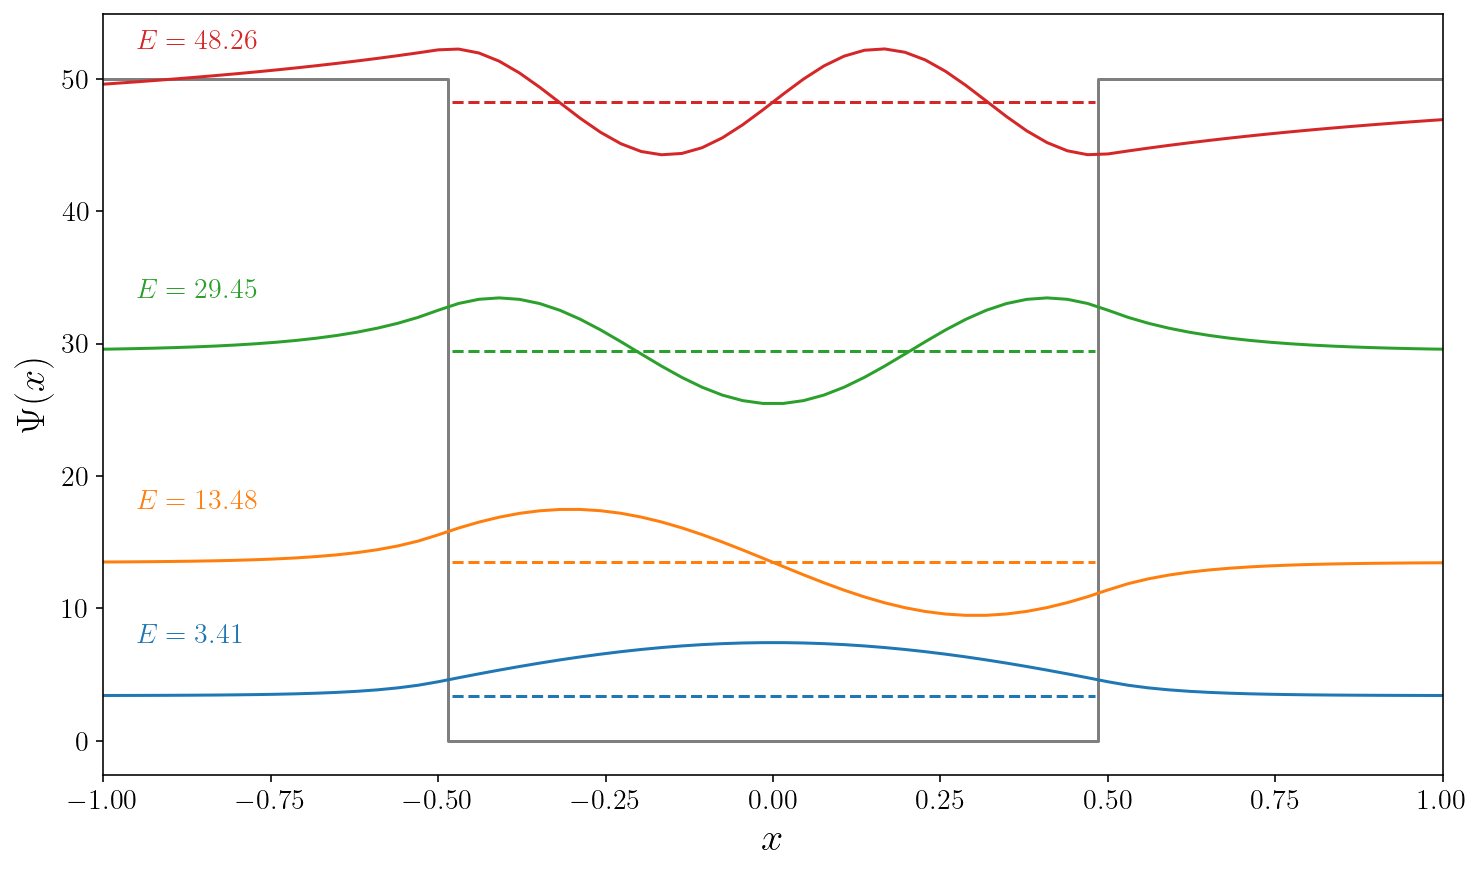

In [11]:
plt.plot(x_plot, V(x_plot), drawstyle='steps-mid', c='k', alpha=0.5)
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    En = soln.p[0]
    l = plt.plot(x_plot, 4 * y_plot / y_plot.max() + En)
    plt.axhline(En, xmin=0.26, xmax=0.74, ls='--', c=l[0].get_color())
    plt.text(-0.95, En + 4, f"$E = {En:.2f}$", color=l[0].get_color(), fontsize=14)
plt.axis(xmin=-1, xmax=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\Psi(x)$')
plt.show()

De los resultados se pueden observar varias cosas:

* Hay un número finito de autoestados para los cuales el electrón está confinado por el potencial $V_0$. 
* Las funciones de onda son similares a las del pozo infinito de potencial.
* La función de onda no se anula en la frontera del pozo, sino que tunela, extendiéndose a las regiones prohibidas clasicamente. Esto indica que existe una probabilidad no nula de que el electrón se encuentre fuera del pozo, mientras permanece confinado en él.

La última observación se puede apreciar claramente al graficar la densitdad de probabilidad $|\Psi|^2$:

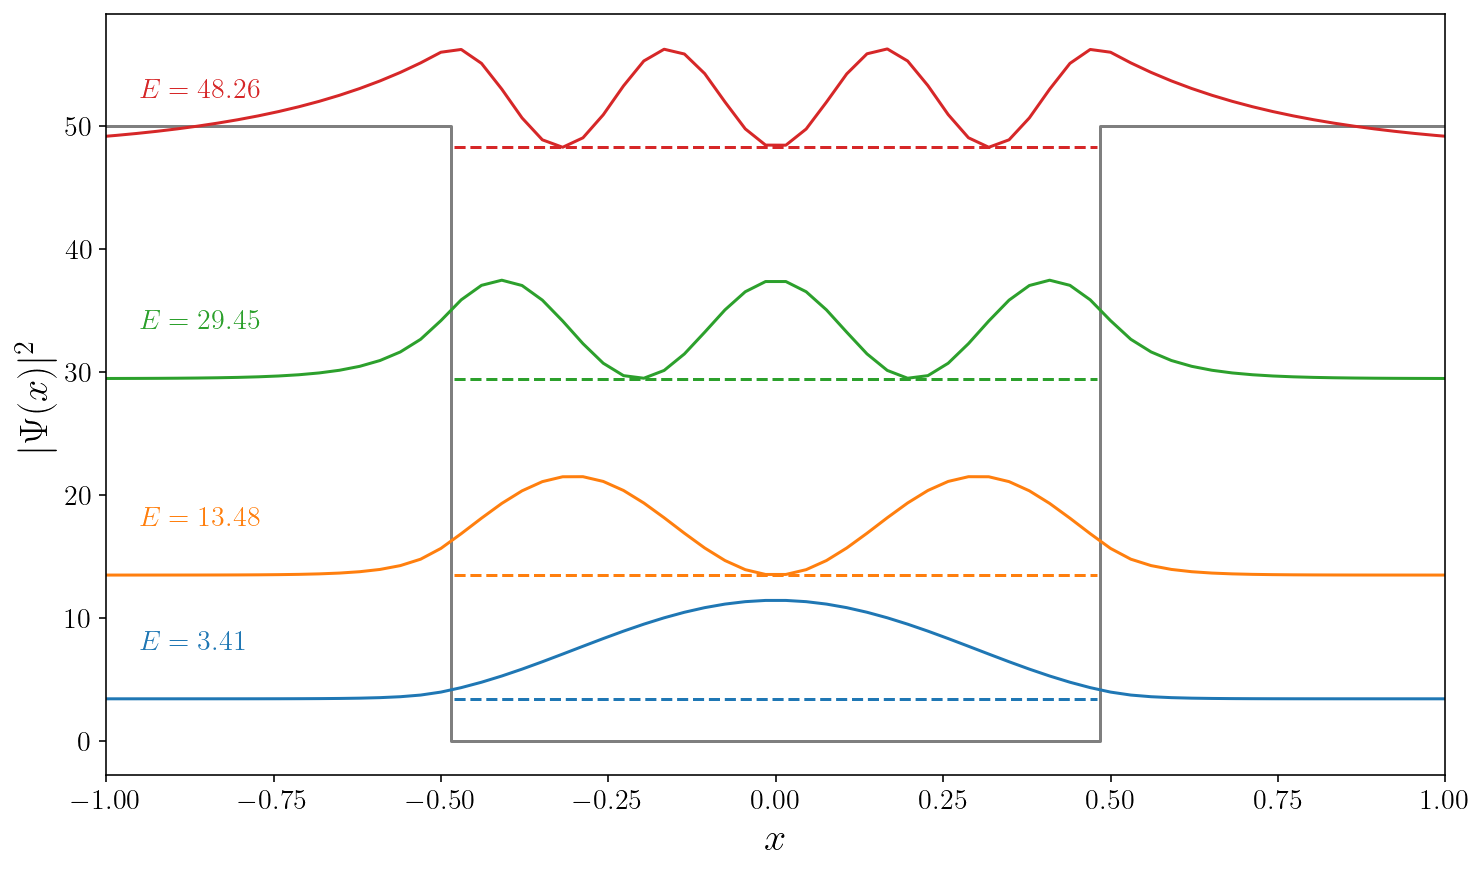

In [12]:
plt.plot(x_plot, V(x_plot), drawstyle='steps-mid', c='k', alpha=0.5)
for soln in solns:
    y_plot = soln.sol(x_plot)[0]
    En = soln.p[0]
    l = plt.plot(x_plot, 8 * y_plot**2 / y_plot.max()**2 + En)
    plt.axhline(En, xmin=0.26, xmax=0.74, ls='--', c=l[0].get_color())
    plt.text(-0.95, En + 4, f"$E = {En:.2f}$", color=l[0].get_color(), fontsize=14)
plt.axis(xmin=-1, xmax=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$|\Psi(x)|^2$')
plt.show()

## Fuentes <a name="bib"></a>

* Paul Harrison, quantum wells, wires and dots, Willey (2005)
* https://github.com/rpanderson/teaching/blob/master/FiniteSquareWellEigenstates.ipynb
* https://physics.weber.edu/schroeder/quantum/Numerical.pdf
* https://cs.westminstercollege.edu/~ccline/courses/phys301/Knight/Knight_41-6.pdf